<a href="https://colab.research.google.com/github/CaioDPires/CaioDPires/blob/main/IPOtrab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho prático 1

Neste trabalho iremos analisar o modelo proposto nas páginas 6-7/13 do artigo 'Ambiente de otimização na web: uma aplicação em timetabling'


## Introdução

Preencher

## Instalação de ferramentas

In [2]:
%pip install gurobipy

In [3]:
import numpy as np
import random
random.seed(11233946) # Seed com número USP

import json
import matplotlib as plt
import time

import os


# --- Set your academic WLS credentials ---
params = {
  'WLSACCESSID':'ec7f97c0-eaa9-42d8-9da6-2c0b6ec47ebc',
  'WLSSECRET':'7fcdea0c-2a61-4ff7-87c8-1b7cba071d9a',
  'LICENSEID':2733505
}



import gurobipy as gp
from gurobipy import GRB


## Modelagem matemática

Nesta seção iremos modelar matematicamente utilizando o *solver* Gurobi o modelo apresentado no enunciado:

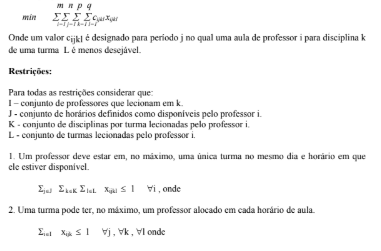
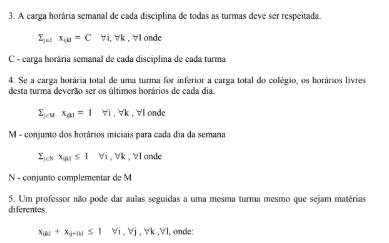

### Índices
$i = 1,..., I →$ Professores;\
$j = 1,..., J →$ Horários;\
$k = 1,..., K →$ Disciplinas;\
$l = 1,..., L →$ Turma.

### Dados de entrada
$c_{ijkl} \in \mathbb{R}^+→$ Custo do professor i ministrar, no período j, a disciplina k para a turma l (Um valor mais alto significa que é menos desejável).\
$C_{kl} \in \mathbb{Z}^+ →$ Carga horária semanal de cada disciplina de cada turma.\
$A_{ij} \in \{0, 1\} →$ Disponibilidade do professor i no horário j. \
$Q_{ik} \in \{0, 1\} →$ Qualificação do professor i para lecionar a disciplina k.

### Variável de decisão
$x_{ijkl} \in \{0, 1\} →$ Variável binária indicando se o professor i ministra, no horário j, a disciplina k para a turma l.

### Função objetivo
$\min \sum_i\sum_j\sum_k\sum_lc_{ijkl}x_{ijkl}$



sujeito a:

#### 1) Professor não pode estar em mais de uma aula em dado horário
$\sum_{k \in K} \sum_{l \in L} x_{ijkl} \le 1\quad \forall i \in I, \forall j \in J$
<br><br>
#### 2) Uma turma não pode ter aula com dois professores simultaneamente (mesmo sendo disciplinas diferentes)
$\sum_{i \in I} \sum_{k \in K} x_{ijkl} \le 1
\quad \forall j \in J, \forall l \in L$

<br><br>
#### 3) Atender a carga horária de cada disciplina k para cada turma l.
$\sum_{i \in I} \sum_{j \in J} x_{ijkl} = C_{kl}
\quad \forall k \in K, \forall l \in L$
<br><br>
#### 4) Se a carga horária de uma turma em dado dia é menor que a carga total do colégio, os horários livres desta turma deverão ser os últimos horários do dia.
Considere $M_d \subseteq J$ como o conjunto dos primeiros horários de cada dia,
e $N_d = J \setminus M_d$ como o conjunto dos demais horários. \
Então:<br>
$
\sum_{j \in M_d} {x_{ijkl}} = 1
\quad \forall i \in I, \forall k \in K, \forall l \in L$\
$
\sum_{j \in N_d} x_{ijkl} \le 1
\quad \forall i \in I, \forall k \in K, \forall l \in L
$ \
(Heurística para forçar os primeiros horários de cada dia a serem ocupados,
que não garante a restrição mas evita infactibilidade)
<br><br>
#### 5) Um professor i não pode ministrar duas aulas consecutivas a uma mesma turma l em um dia. Isto é, se j e j+1representam períodos consecutivos do mesmo dia, então:
$
\sum_{k, k'}(x_{ijkl}+x_{i,j+1,k'l}) \le1 \quad \forall{i, l, d}
$\
($d$ sendo o dia da semana)
(Tomei a liberdade de modelar desta forma, pois em dias consecutivos estava causando muita infactibilidade por conflitos com a restrição 4.)
<br><br>
(Modelamos as duas restrições abaixo de uma forma menos formal, mas mais semelhante ao modo como o solver vai enxergar as restrições, por eficiência. Modelar com <= provavelmente vai custar um bom tempo já que o solver terá que ficar rastreando essa restrição.)
<br><br>
#### 6) Um professor i só pode ministrar a disciplina k se for qualificado
$x_{ijkl} ​= 0\quad \forall{i}\in I,\forall{j} \in J, \forall{k} \in K, \forall{l} \in L$ se $Q_{ik}​=0$
<br><br>
#### 7) Um professor i só pode ministrar uma disciplina no horário j se estiver disponível.
$x_{ijkl} = 0 \quad \forall{i}\in I,\forall{j} \in J, \forall{k} \in K, \forall{l} \in L$ se $A_{ij} = 0$

## Modelagem no Gurobipy

In [15]:
import gurobipy as gp
from gurobipy import GRB

def criar_e_resolver(model, dados, instancia="teste", periods_per_day=6):
    print("\nGerando modelo e adicionando restrições")

    numI = len(dados["c"])
    numJ = len(dados["c"][0])
    numK = len(dados["c"][0][0])
    numL = len(dados["c"][0][0][0])

    # --- Criar variáveis apenas quando possíveis ---
    x = {}
    for i in range(numI):
        for j in range(numJ):
            for k in range(numK):
                for l in range(numL):
                    if dados["A"][i][j] and dados["Q"][i][k]:
                        x[i, j, k, l] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}_{k}_{l}")

    # --- Desativar output ---
    model.Params.LogToConsole = 0
    model.Params.OutputFlag = 1
    model.Params.LogFile = f"log_{instancia}.txt"

    # --- Função objetivo ---
    model.setObjective(
        gp.quicksum(
            dados["c"][i][j][k][l] * x[i, j, k, l]
            for (i, j, k, l) in x
        ),
        GRB.MINIMIZE
    )

    # --- Restrição 1: Um professor não pode estar em dois lugares ao mesmo tempo ---
    for i in range(numI):
        for j in range(numJ):
            model.addConstr(
                gp.quicksum(x[i, j, k, l] for k in range(numK) for l in range(numL)
                            if (i, j, k, l) in x) <= 1,
                name=f"onipresenca_{i}_{j}"
            )

    # --- Restrição 2: Uma turma só pode ter um professor em cada horário ---
    for j in range(numJ):
        for l in range(numL):
            model.addConstr(
                gp.quicksum(x[i, j, k, l] for i in range(numI) for k in range(numK)
                            if (i, j, k, l) in x) <= 1,
                name=f"um_prof_por_turma_{j}_{l}"
            )

    # --- Restrição 3: Carga horária da disciplina ---
    for k in range(numK):
        for l in range(numL):
            model.addConstr(
                gp.quicksum(x[i, j, k, l] for i in range(numI) for j in range(numJ)
                            if (i, j, k, l) in x) == dados["C"][k][l],
                name=f"carga_horaria_{k}_{l}"
            )

    # --- Restrição 4: Ocupação dos primeiros horários ---
    Md = set(range(0, numJ, periods_per_day))
    Nd = set(range(numJ)) - Md

    num_dias = len(range(numJ)) // periods_per_day
    J_dias = [list(range(d * periods_per_day, (d + 1) * periods_per_day)) for d in range(num_dias)]

    for l in range(numL):
        for j in Md:
            model.addConstr(
                gp.quicksum(x[i, j, k, l] for i in range(numI) for k in range(numK)
                            if (i, j, k, l) in x) == 1,
                name=f"ocupacao_inicial_l{l}_j{j}"
            )
        for j in Nd:
            model.addConstr(
                gp.quicksum(x[i, j, k, l] for i in range(numI) for k in range(numK)
                            if (i, j, k, l) in x) <= 1,
                name=f"ocupacao_tardia_l{l}_j{j}"
            )

    # --- Restrição 5: Professor não dá duas aulas seguidas para a mesma turma ---
    for d, slots_dia in enumerate(J_dias):
        for i in range(numI):
            for l in range(numL):
                for idx in range(len(slots_dia) - 1):
                    j = slots_dia[idx]
                    j_next = slots_dia[idx + 1]
                    model.addConstr(
                        gp.quicksum(x[i, j, k, l] for k in range(numK)
                                    if (i, j, k, l) in x) +
                        gp.quicksum(x[i, j_next, k, l] for k in range(numK)
                                    if (i, j_next, k, l) in x) <= 1,
                        name=f"nao_seguidas_d{d}_i{i}_l{l}_j{j}"
                    )

    model.update()
    print(f"Modelo '{instancia}' gerado com {len(x)} variáveis e {model.NumConstrs} restrições.\n")

    # --- Callback para progresso ---
    progress_log = []
    def progress_callback(model, where):
        if where == GRB.Callback.MIP:
            runtime = model.cbGet(GRB.Callback.RUNTIME)
            best_obj = model.cbGet(GRB.Callback.MIP_OBJBST)
            best_bound = model.cbGet(GRB.Callback.MIP_OBJBND)
            progress_log.append((runtime, best_obj, best_bound))

    print("Otimizando...")
    model.optimize(progress_callback)
    print(f"Tempo de otimização: {model.Runtime:.2f} segundos")

    return x, progress_log


In [5]:
# Função que gera dados (semi-)aleatoriamente para o modelo
def gerar_dados(
  seed=42,
  numI=4,
  periods_per_day=6,
  days=5,
  numK=5,
  numL=2,
  probQ=0.8,
  probA=0.9,
  max_per_subject_per_class=3,
  target_utilization=0.6
):
    """
    Gera dados coerentes (C assegura soma_k C[k,l] <= numJ).
    target_utilization: fração média de ocupação por turma (0..1).
    """
    rng = np.random.default_rng(seed)
    numJ = periods_per_day * days

    # custos
    c = rng.integers(1, 10, size=(numI, numJ, numK, numL)).tolist()

    # Qualificações: garantir que cada disciplina tem pelo menos 1 professor
    Q = (rng.random((numI, numK)) < probQ).astype(int)
    # ensure at least one qualified per discipline
    for k in range(numK):
        if Q[:, k].sum() == 0:
            Q[rng.integers(0, numI), k] = 1
    Q = Q.tolist()

    # Disponibilidade: pra evitar infactibilidade, garantir que cada period/j há algum prof disponível
    A = (rng.random((numI, numJ)) < probA).astype(int)
    # If some period has zero available profs, force one random prof to be available
    for j in range(numJ):
        if A[:, j].sum() == 0:
            A[rng.integers(0, numI), j] = 1
    A = A.tolist()

    # Gerar C[k][l] com soma por coluna <= numJ * target_utilization (mantendo folga)
    C = np.zeros((numK, numL), dtype=int)
    max_slots_per_class = int(numJ * target_utilization)
    for l in range(numL):
        remaining = max_slots_per_class
        # distribute randomly among disciplines, but ensure last ones can be zero
        for k in range(numK):
            if k == numK - 1:
                C[k, l] = remaining if rng.random() < 0.5 else rng.integers(0, min(max_per_subject_per_class, remaining) + 1)
            else:
                cap = min(max_per_subject_per_class, remaining)
                if cap <= 0:
                    C[k, l] = 0
                else:
                    # skew toward small numbers
                    C[k, l] = int(rng.integers(0, cap + 1))
                remaining -= C[k, l]
    C = C.tolist()

    return {"c": c, "C": C, "Q": Q, "A": A}

In [18]:
# Função utilitária para printar resultados do modelo
def printar_resultados(model, dados, x):
    print("\n\n--- Resultados da solução ---\n")

    if model.Status == GRB.INFEASIBLE:
        print("⚠️  Modelo infactível.")
        model.computeIIS()
        filename = f"infactibilidade_{model.ModelName}.ilp"
        model.write(filename)
        print(f"Arquivo '{filename}' gerado — verifique as restrições conflitantes.")
        return

    print(f"Status: {'ótima' if model.Status == GRB.OPTIMAL else 'não ótima'}")
    print(f"Melhor valor da função objetivo: {model.ObjVal:.2f}")
    print(f"Gap de otimalidade: {model.MIPGap:.4f}\n")

    # Caso simples: mostrar variáveis com valor positivo
    if 'simples' in model.ModelName or len(x) < 500:
        print("Soluções não nulas (x[i,j,k,l] = 1):")
        count = 0
        for (i, j, k, l), var in x.items():
            if var.X > 0.5:
                print(f"  x[{i},{j},{k},{l}] = 1")
                count += 1
        if count == 0:
            print("  Nenhuma variável ativa encontrada.")

In [19]:
# Função utilitária para printar detalhes da instância
def printar_dados_entrada(dados):
  numI = len(dados["c"])
  numJ = len(dados["c"][0])
  numK = len(dados["c"][0][0])
  numL = len(dados["c"][0][0][0])

  print(f"\nDimensões: Professores: {numI}, Horários: {numJ}, Disciplinas: {numK}, Turmas: {numL}")

  print("\nCargas horárias:")
  for k in range(numK):
      for l in range(numL):
          print(f"  Disciplina {k}, turma {l}: {dados['C'][k][l]}")

  print("\nCustos:")
  for i in range(numI):
      print(f"Professor {i}:")
      for j in range(numJ):
          custos = " ".join(
              f"{dados['c'][i][j][k][l]:.1f}"
              for k in range(numK)
              for l in range(numL)
          )
          print(f"  j={j}: {custos}")
      print("-" * 40)

In [20]:
### Instância simples 1
model_s1 = gp.Model(env=gp.Env(params=params), name="Modelo da instância simples 1")
# formular e resolver modelo
nomeInstancia = "instancia_simples_1"
periods_per_d = 2
dados_s1 = gerar_dados(numI = 2, numK = 2, numL = 1, periods_per_day = periods_per_d, days = 1, probQ = 1, probA = 1, seed=11233946)

x_s1, _ = criar_e_resolver(model_s1, dados_s1, nomeInstancia, periods_per_day = periods_per_d)

printar_dados_entrada(dados_s1)

printar_resultados(model_s1, dados_s1, x_s1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2733505
Academic license 2733505 - for non-commercial use only - registered to ca___@usp.br

Gerando modelo e adicionando restrições
Set parameter LogToConsole to value 0
Modelo 'instancia_simples_1' gerado com 8 variáveis e 12 restrições.

Otimizando...
Tempo de otimização: 0.00 segundos

Dimensões: Professores: 2, Horários: 2, Disciplinas: 2, Turmas: 1

Cargas horárias:
  Disciplina 0, turma 0: 1
  Disciplina 1, turma 0: 0

Custos:
Professor 0:
  j=0: 1.0 8.0
  j=1: 8.0 5.0
----------------------------------------
Professor 1:
  j=0: 8.0 2.0
  j=1: 6.0 8.0
----------------------------------------


--- Resultados da solução ---

Status: ótima
Melhor valor da função objetivo: 1.00
Gap de otimalidade: 0.0000

Soluções não nulas (x[i,j,k,l] = 1):
  x[0,0,0,0] = 1


## Discussão dos resultados da instância simples 1 (sem alterações)

A instância acima é trivial. Temos 2 professores, 2 matérias, 2 horários e apenas uma turma. A carga horária da disciplina 2 é 0, o que a remove da equação, e a carga horária da disciplina 1 é apenas 1.
Além disso, por ter setado $probA = 1$ e $probQ = 1$, ambos os professores são totalmente qualificados para ministrar ambas as disciplinas.
Desta forma, fica óbvio que a melhor solução é apenas o horário e professor de menor custo (permidito pelas restrições), que, nesse caso, acabou sendo o menor custo entre todos.

A seguir, vamos fazer algumas alterações nos dados de entrada para visualizar o efeito no comportamento do modelo.

In [21]:
### Instância simples 1 com custos modificados
model_s1_mod1 = gp.Model(env=gp.Env(params=params), name="Modelo da instância simples 1 - custos modificados")
# formular e resolver modelo
nomeInstancia = "instancia_simples_1_mod_1"
# Modificando os pesos da função objetivo
dados_s1_mod1 = dados_s1
dados_s1_mod1["c"][0][0][0][0] = 10
dados_s1_mod1["c"][1][0][0][0] = 10

x_s1_mod1, _ = criar_e_resolver(model_s1_mod1, dados_s1_mod1, nomeInstancia, periods_per_day = periods_per_d)

printar_dados_entrada(dados_s1_mod1)

printar_resultados(model_s1_mod1, dados_s1_mod1, x_s1_mod1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2733505
Academic license 2733505 - for non-commercial use only - registered to ca___@usp.br

Gerando modelo e adicionando restrições
Set parameter LogToConsole to value 0
Modelo 'instancia_simples_1_mod_1' gerado com 8 variáveis e 12 restrições.

Otimizando...
Tempo de otimização: 0.00 segundos

Dimensões: Professores: 2, Horários: 2, Disciplinas: 2, Turmas: 1

Cargas horárias:
  Disciplina 0, turma 0: 1
  Disciplina 1, turma 0: 0

Custos:
Professor 0:
  j=0: 10.0 8.0
  j=1: 8.0 5.0
----------------------------------------
Professor 1:
  j=0: 10.0 2.0
  j=1: 6.0 8.0
----------------------------------------


--- Resultados da solução ---

Status: ótima
Melhor valor da função objetivo: 10.00
Gap de otimalidade: 0.0000

Soluções não nulas (x[i,j,k,l] = 1):
  x[0,0,0,0] = 1


### Discussão dos resultados da instância simples 1 (com custos modificados)
&nbsp;&nbsp;&nbsp;&nbsp;À primeira vista, os resultados obtidos acima parecem estranhos. Afinal, porquê a solução ótima seria 10, quando temos várias possibilidades de menor custo? Mas a resposta é simples: restrições.
Em primeiro lugar, os outros horários e disciplinas estão bloqueados por restrições. Todos os x da segunda coluna (8.0, 5.0, 2.0 e 8.0) correspondem à segunda disciplina, cuja carga horária é 0 (ao ler isso pensei que deveria ter modelado maior ou igual, mas não faz sentido já que estamos minimizando o objetivo) e o 6.0 encontrado em x[1, 1, 0, 0] é impedido pela restrição 4, que força o primeiro horário de cada dia a ser ocupado.

&nbsp;&nbsp;&nbsp;&nbsp;Surge outra dúvida: porquê não x[1, 0, 0, 0], então? É o mesmo custo, e não aparenta estar bloqueado por nenhuma restrição, mas ao printar `model.SolCount`, o output é 1. O que acontece é que o Gurobi não enumera diversas soluções ótimas; ele para a execução ao provar otimalidade, indexando apenas uma solução ótima.




In [22]:
### Instância simples 1 com restrições modificadas
model_s1_mod2 = gp.Model(env=gp.Env(params=params), name="Modelo da instância simples 1 - restrições modificadas")
# formular e resolver modelo
nomeInstancia = "instancia_simples_1_mod_2"

# Modificando as restrições
dados_s1_mod2 = dados_s1
dados_s1_mod2["Q"][0][0] = 0

x_s1_mod2, _ = criar_e_resolver(model_s1_mod2, dados_s1_mod2, nomeInstancia, periods_per_day = periods_per_d)

printar_dados_entrada(dados_s1_mod2)

printar_resultados(model_s1_mod2, dados_s1_mod2, x_s1_mod2)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2733505
Academic license 2733505 - for non-commercial use only - registered to ca___@usp.br

Gerando modelo e adicionando restrições
Set parameter LogToConsole to value 0
Modelo 'instancia_simples_1_mod_2' gerado com 6 variáveis e 12 restrições.

Otimizando...
Tempo de otimização: 0.00 segundos

Dimensões: Professores: 2, Horários: 2, Disciplinas: 2, Turmas: 1

Cargas horárias:
  Disciplina 0, turma 0: 1
  Disciplina 1, turma 0: 0

Custos:
Professor 0:
  j=0: 10.0 8.0
  j=1: 8.0 5.0
----------------------------------------
Professor 1:
  j=0: 10.0 2.0
  j=1: 6.0 8.0
----------------------------------------


--- Resultados da solução ---

Status: ótima
Melhor valor da função objetivo: 10.00
Gap de otimalidade: 0.0000

Soluções não nulas (x[i,j,k,l] = 1):
  x[1,0,0,0] = 1


&nbsp;&nbsp;&nbsp;&nbsp;Para a segunda alteração nesta instância, optamos por impossibilitar o professor 0 de ministrar a matéria 0, pois isso pareceu um follow-up lógico após o resultado da primeira alteração. \
&nbsp;&nbsp;&nbsp;&nbsp;Assim validamos que este comportamento é o esperado do Gurobi. Vemos, acima, que ao impossibilitar o professor 0 de ministrar a disciplina 0, a única solução possível se torna x[1, 0, 0, 0], como era esperado.

In [25]:
### Instância complexa 1
model_c1 = gp.Model(env=gp.Env(params=params), name="Modelo da instância complexa 1")
nomeInstancia = "instancia_complexa_1"
periods_per_d = 20

dados_c1 = gerar_dados(numI = 100, numK = 30, numL = 30, periods_per_day = periods_per_d, days = 10, probQ = 0.4, probA = 0.4)

x_c1, progress_log_1 = criar_e_resolver(model_c1, dados_c1, nomeInstancia, periods_per_day = periods_per_d)

printar_resultados(model_c1, dados_c1, x_c1)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2733505
Academic license 2733505 - for non-commercial use only - registered to ca___@usp.br

Gerando modelo e adicionando restrições
Set parameter LogToConsole to value 0
Modelo 'instancia_complexa_1' gerado com 2935890 variáveis e 602900 restrições.

Otimizando...
Tempo de otimização: 126.89 segundos


--- Resultados da solução ---

Status: ótima
Melhor valor da função objetivo: 2561.00
Gap de otimalidade: 0.0000



In [23]:
model_c1.dispose()

[(111.72871398925781, 13084.0, 0.0), (111.8127019405365, 13084.0, 0.0), (125.64560198783875, 2561.0, 2561.0)]


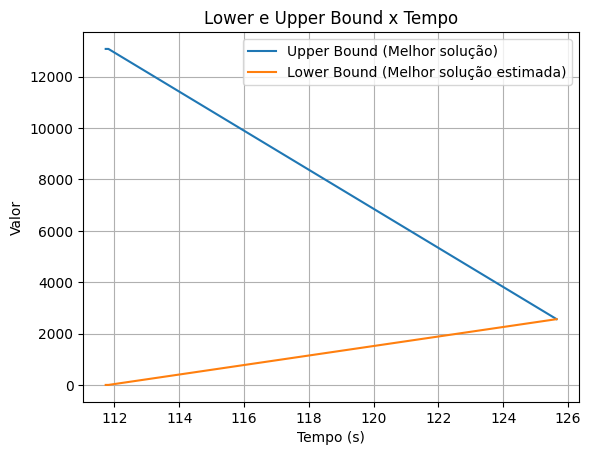

In [13]:
import matplotlib.pyplot as plt
print(progress_log_1)
times = [t for t, _, _ in progress_log_1]
best_obj = [o for _, o, _ in progress_log_1]
best_bound = [b for _, _, b in progress_log_1]

plt.plot(times, best_obj, label="Upper Bound (Melhor solução)")
plt.plot(times, best_bound, label="Lower Bound (Melhor solução estimada)")
plt.xlabel("Tempo (s)")
plt.ylabel("Valor")
plt.title("Lower e Upper Bound x Tempo")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
### Instância complexa 2 (não fiz funcionar ainda, modifica ae @Fabiao)
model_c2 = gp.Model(env=gp.Env(params=params), name="Modelo da instância complexa 2")
nomeInstancia = "instancia_complexa_2"
periods_per_d = 15

dados_c2 = gerar_dados(seed =12345678, numI = 70, numK = 30, numL = 15, periods_per_day = periods_per_d, days = 10, probQ = 0.7, probA = 0.7)

x_c2, progress_log_1 = criar_e_resolver(model_c2, dados_c2, nomeInstancia, periods_per_day = periods_per_d)

printar_resultados(model_c2, dados_c2, x_c2, I_c2, J_c2, K_c2, L_c2)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2733505
Academic license 2733505 - for non-commercial use only - registered to ca___@usp.br

Gerando modelo e adicionando restrições
Set parameter LogToConsole to value 0
Modelo 'instancia_complexa_2' gerado com 2328945 variáveis e 162450 restrições.

Otimizando...
Tempo de otimização: 77.98 segundos


NameError: name 'I_c2' is not defined

#

In [24]:
model_s1.dispose()
model_s1_mod1.dispose()
model_s1_mod2.dispose()
model_c1.dispose()
model_c2.dispose()